TR AUTO - run 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys
import os

sys.path.append('..')
import irdetection.analysis.fitting.models as md
from irdetection.analysis.fitting.FitAPI import Fitter
from irdetection.analysis.fitting.models import Model
from irdetection.analysis.fitting.searcher import ResonancePeakSearcher
from irdetection.graphics.plots import plot_fit
from irdetection.graphics.colours import Palette
from irdetection.graphics.typography import Typography, Font
from irdetection.graphics.plots import plot
from irdetection.graphics.palettes import QSciencePalette, QScienceTypography

In [2]:
# graphics settings
palette = Palette("Quantum Science", {
    'primary': "#046A3A",      # Deep ocean blue - sophisticated and trustworthy
    'secondary': '#1B263B',    # Midnight navy - elegant depth
    'accent': "#E65039",       # Vibrant coral - high-impact highlights
    'accent2': '#FFD23F',      # Golden yellow - energy and precision
    'background': '#F8F9FB',   # Ultra-clean off-white - pristine lab feel
    'background2': '#E8EDF3',  # Subtle blue-gray - sophisticated secondary
    'text_primary': '#1A1B23', # Rich charcoal - maximum readability
    'text_secondary': '#4A5568', # Cool gray - perfect for secondary text
    'status_error': '#E53E3E',  # Crisp red - clear error indication
    'neutral_light' : '#FFFFFF',
    'neutral_dark': "#2D3748",   # Professional dark gray - strong borders
})

typography = Typography(
    title=Font('Palatino Linotype', 20, family='serif'),   
    subtitle=Font('Verdana', 16, family='sans-serif'),
    body=Font('Verdana', 13, family='sans-serif'),    
    caption=Font('Verdana', 11, family='sans-serif')  
)

In [3]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

## Peak at 6.23 MHz (run-0)

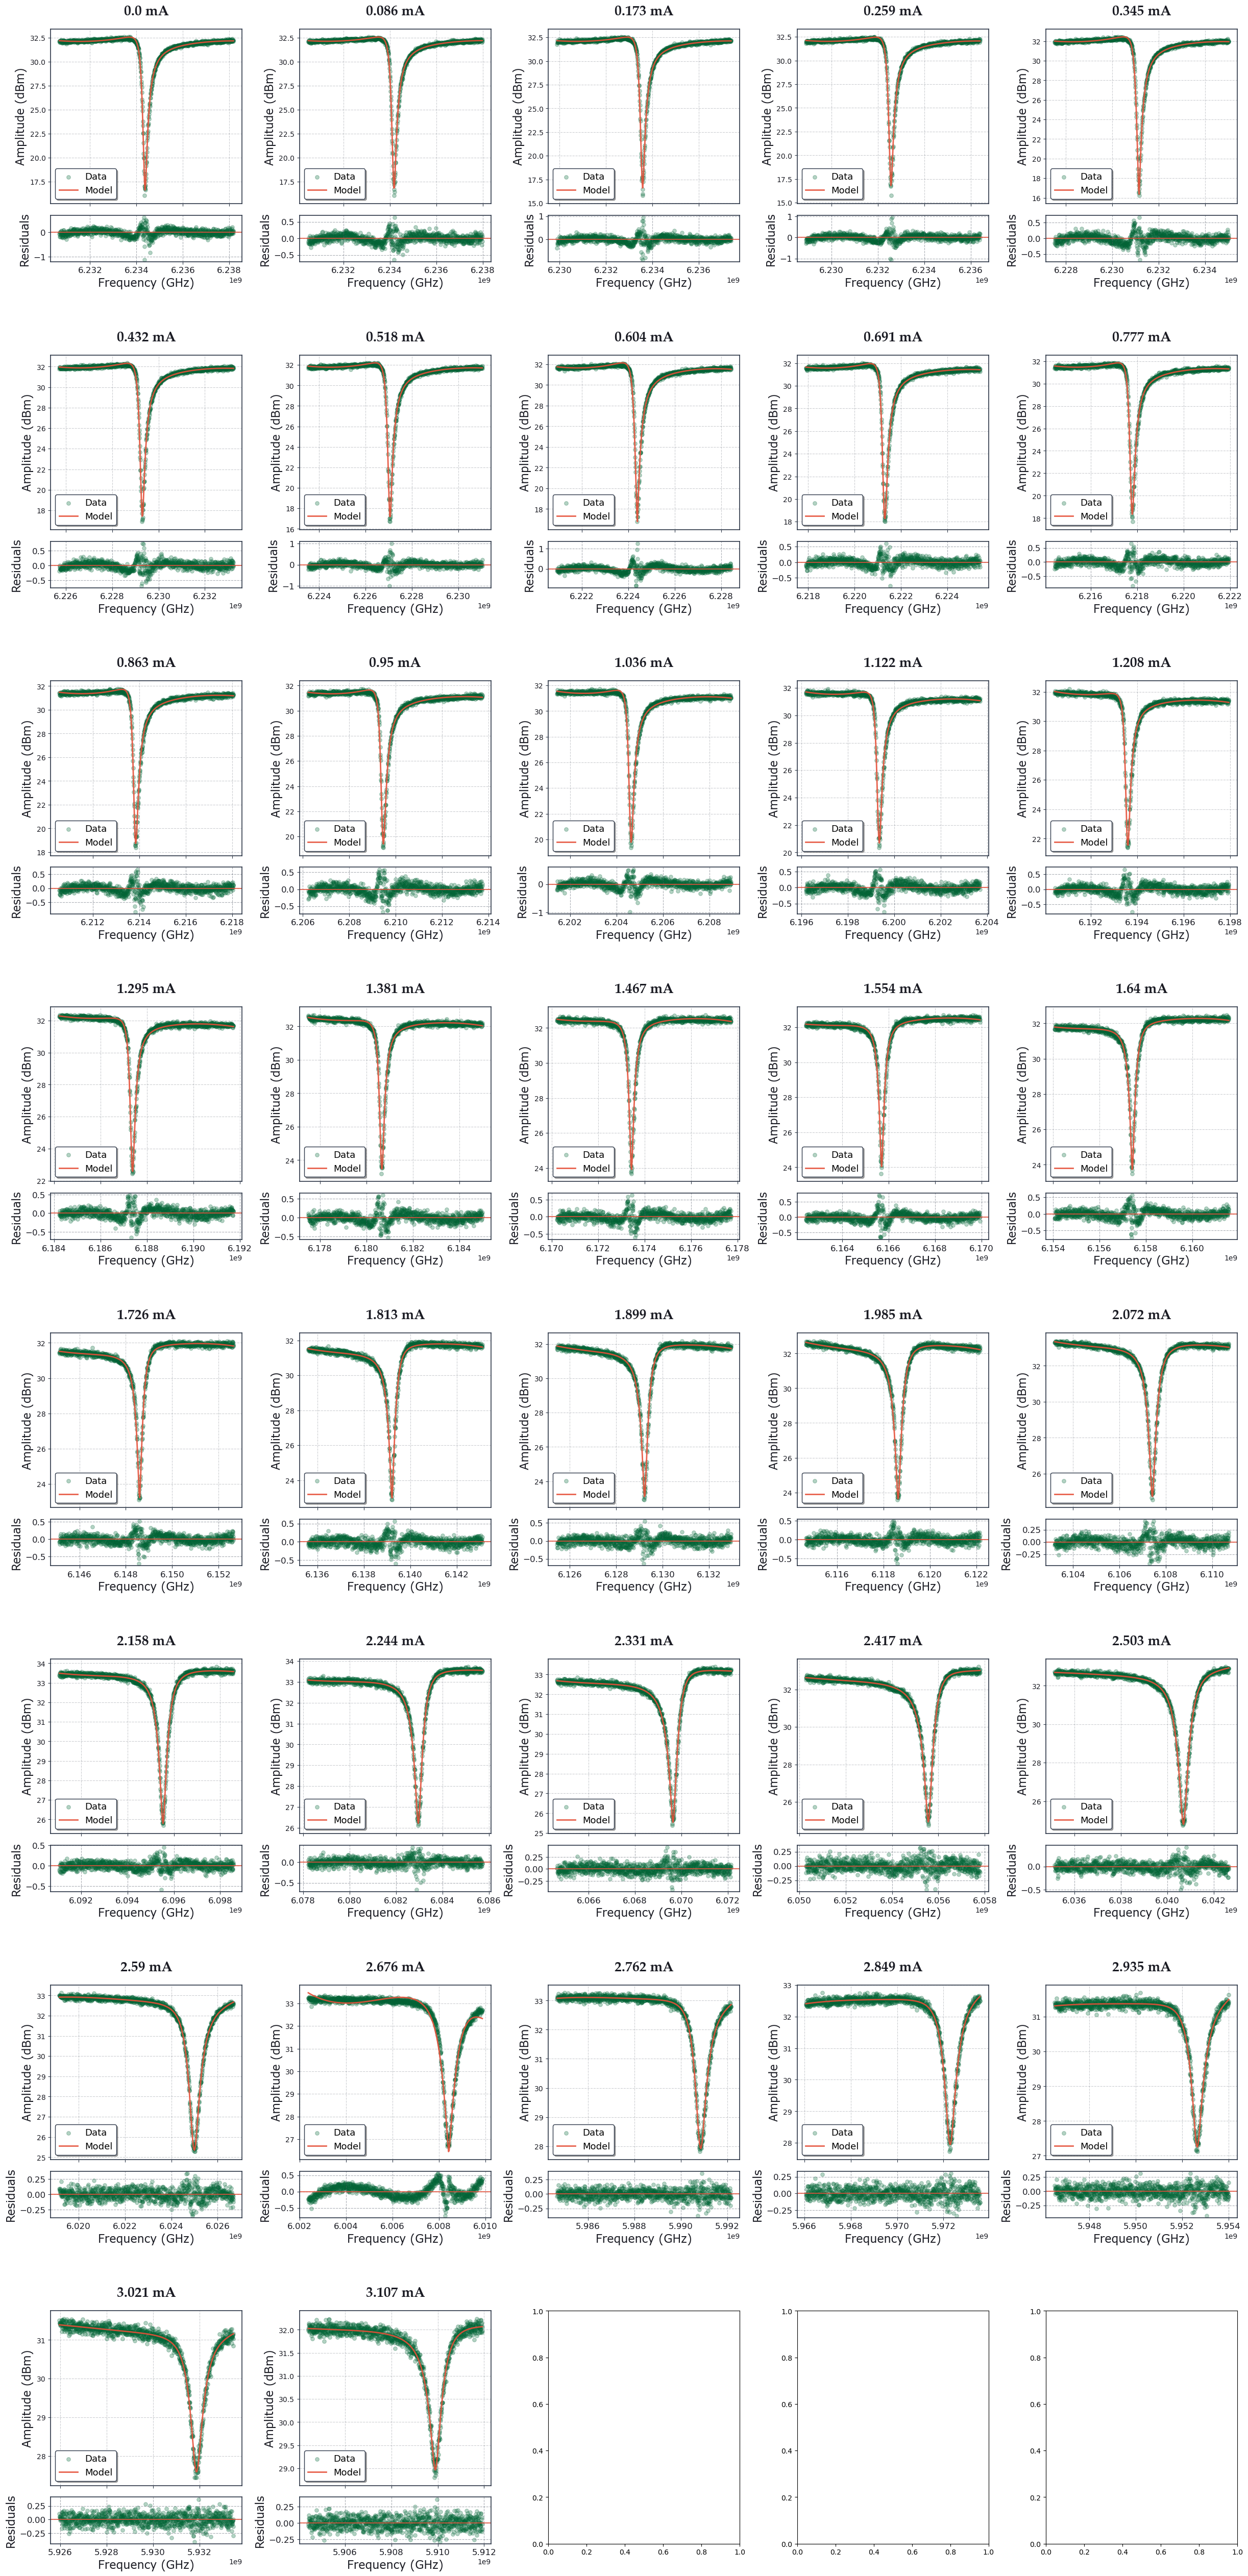

In [4]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces_1 = []
bias_currents_1 = []
Qt_1 = []
Qc_1 = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    
    # try to fit
    model = md.resonance_model
    
    
    def Loss(*params):
        """Loss function for the resonance model."""
        print(f"Fitting parameters: {params[0]}")
        x, y, yerr, model, names = params
        f0, phi, Qt, Qc, A, B, C, D, K, fmin = [x[names.index(name)] for name in names]
        model_values = model(f0=f0, phi=phi, Qt=Qt, Qc=Qc, A=A, B=B, C=C, D=D, K=K, fmin=fmin)
        ls = np.sum((x - model_values) ** 2)
        if Qc <= Qt:
            ls += 100  # Penalize if Qc is smaller than Qt
        return ls
    
    fitter = Fitter(model_function=model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_manager=LeastSquares
                    )

    searcher = ResonancePeakSearcher(version="T")
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces_1.append(resonance_frequency)
            bias_currents_1.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces_1.append(resonance_frequency)
            bias_currents_1.append(bias_current)
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'{round(bias_current, 3)} mA', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=palette, 
                     typography=typography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
            
            Qt_1.append(fitted_params['Qt'])
            Qc_1.append(fitted_params['Qc'])
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces_1.append(resonance_frequency)
        #bias_currents.append(bias_current)
        
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    


plt.show()


In [5]:
print(f'Qt: {Qt_1}')
print(f'Qc: {Qc_1}')

Qt: [17792.54169022748, 17670.639566467195, 17852.72195121923, 17963.019596695663, 16240.120674981263, 17735.781110973516, 18052.275731827438, 15987.78495342068, 20288.723286844834, 19916.945174908717, 20860.44972447576, 21082.512308951416, 20743.805343206855, 20563.71124301626, 20982.597720878293, 19176.71529602427, 19327.239409275833, 16955.542491158827, 16120.426664336663, 14868.814386080898, 13791.978405776617, 12707.86801907009, 11951.908702030334, 11214.60032924071, 10487.133752898892, 10220.8929663683, 10018.57081694646, 9303.323672418817, 8648.487971997243, 8057.152616425256, 8168.909821795744, 5891.133879816768, 8110.768794246659, 7465.544198036467, 6855.958606411527, 7005.0266928500805, 6311.969965248077]
Qc: [14363.235936746265, 14192.836187221224, 22272.470112579267, 13986.88713880991, 16593.023735881896, 23059.28683148939, 22964.59383747895, 15984.307823356248, 55351.99375825639, 41726.95893521372, 58797.16657570589, 76039.64719714751, 48320.76730993562, 12571.344921858406

In [6]:
# #Save the figure a svg file
# fig.savefig('../Analysis/figures/resonance_peaks_tunable_1.svg', bbox_inches='tight', dpi=300)

## F and Q analysis

In [7]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces_1)
bias_currents = np.array(bias_currents_1)
resonance_frequneces_normalized -= resonance_frequneces_1[0]
resonance_frequneces_normalized /= resonance_frequneces_1[0] if resonance_frequneces_1[0] != 0 else 1

I_2 = 10.77530039238516 +- 0.7028995027157322 mA
I_4 = 8.272698492133518 +- 2.652788548891017 mA


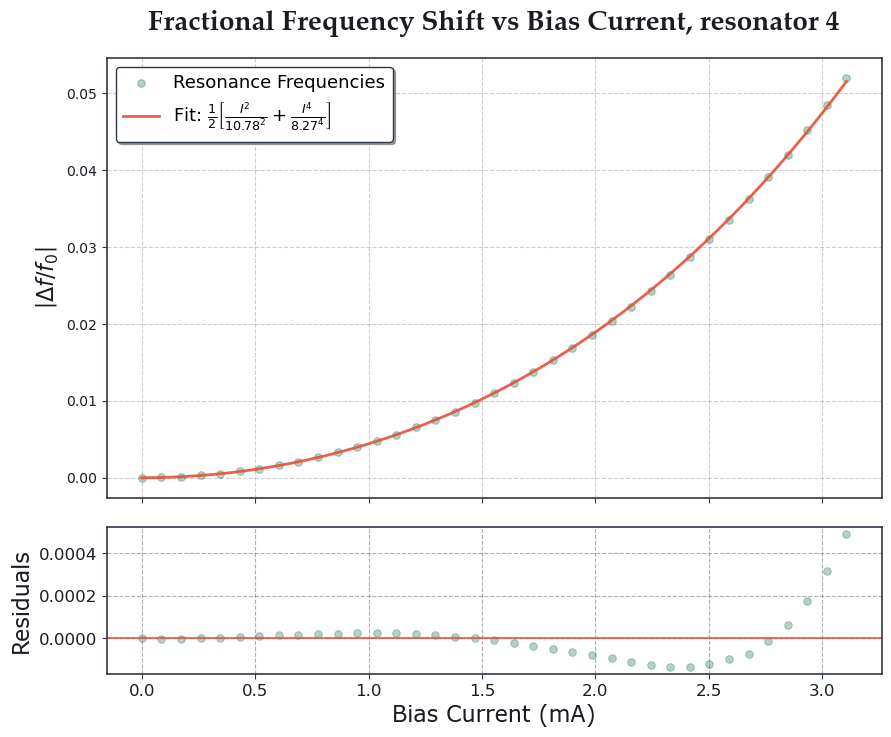

In [8]:
import matplotlib as mpl

# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, abs(resonance_frequneces_normalized)]).T, 
                    loss_manager=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()
error_params = result.errors.to_dict()
print(f"I_2 = {fitted_params["a"]} +- {error_params["a"]} mA")
print(f"I_4 = {fitted_params["b"]} +- {error_params["b"]} mA")

#model: 0.5*((i**2 / a**2) + (i**4 / b**4))

data = np.array([bias_currents, abs(resonance_frequneces_normalized)]).T
# Plot using LaTeX for text rendering
# enable LaTeX

# disable LaTeX rendering and use mathtext (Matplotlib's built-in math renderer)
mpl.rcParams['text.usetex'] = False

plot_fit(
    data=data,
    model=model,
    model_params=fitted_params,
    title=r'Fractional Frequency Shift vs Bias Current, resonator 4',
    xlabel=r'Bias Current (mA)',
    ylabel=r'$\left|\Delta f / f_0\right|$',  # mathtext will still render this correctly
    data_label=r'Resonance Frequencies',
    model_label=(
        r'Fit: $\frac{1}{2}\left[\frac{I^2}{%.2f^2} + \frac{I^4}{%.2f^4}\right]$'
        % (fitted_params["a"], fitted_params["b"])
    ),
    palette=palette,
    typography=typography,
    rasterize_points=False,
)
plt.show()


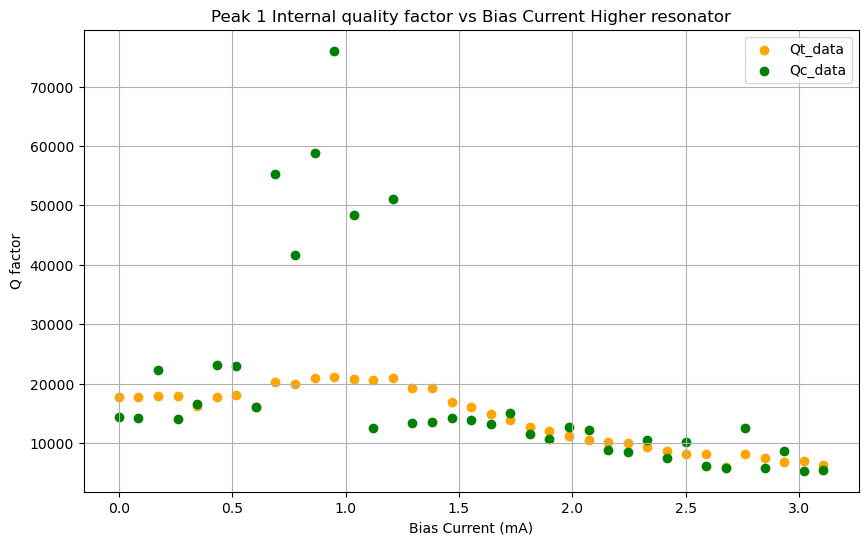

In [9]:
# Qi0 = np.array(Qi_1)[:-7]  # Exclude the last 7 values
# bias_currents = np.array(bias_currents_1)[:-7]  # Exclude the last 7 values
# Qs0 = np.array(Qs_1)  # Assuming Qc is calculated as Qt / Qc
#Qi = (Qc0*Qt0)/(Qc0 - Qt0)  # Assuming Qt is the sum of Qt and Qc
#define 1/Qi array
#Qi_inv = 1 / Qi0

plt.figure(figsize=(10, 6))
# plt.scatter(bias_currents, Qt1, label='Qt_data', color='blue')
plt.scatter(bias_currents, np.array(Qt_1), label='Qt_data', color='orange')
plt.scatter(bias_currents, np.array(Qc_1), label='Qc_data', color='green')
#plt.scatter(bias_currents, np.array(Qi), label='Qi_data', color='blue')
plt.xlabel('Bias Current (mA)')
plt.ylabel('Q factor')
plt.title('Peak 1 Internal quality factor vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()



F(I) gradient plot


In [10]:
peak_data

array([[ 5.88182000e+09,  5.88182751e+09,  5.88183502e+09, ...,
         5.88930498e+09,  5.88931249e+09,  5.88932000e+09],
       [-1.64066927e-02, -1.70615392e-02, -1.62847356e-02, ...,
         3.61652918e-02,  3.53263494e-02,  3.52834024e-02],
       [ 2.74783655e-02,  2.89264500e-02,  2.75738108e-02, ...,
         9.34419210e-03,  9.17023870e-03,  9.40279520e-03]])

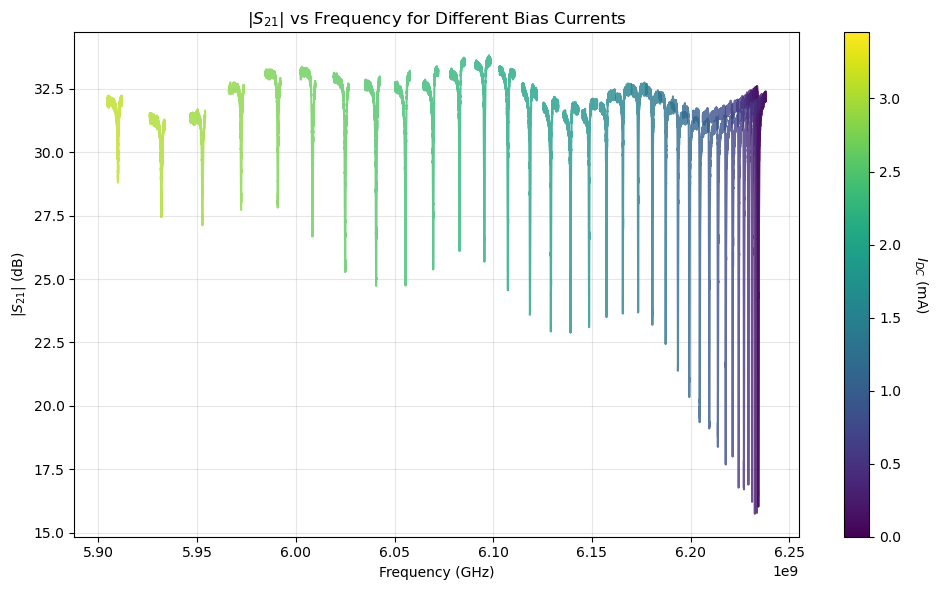

In [11]:

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    S21_mag = 20 * np.log10(amp * 1e3)
    color = cmap(norm(bias_current))
    plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r'$I_{DC}$ (mA)', rotation=270, labelpad=20)

# Formatting
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$|S_{21}|$ (dB)')
plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



GRADIENT PLOT IN PALETTE


In [12]:

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

f = []
S21_mag = []
colors = []

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f.append(peak_data[0])
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    S21_mag.append(20 * np.log10(amp * 1e3)) 
    colors.append(cmap(norm(bias_current)))
    #plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

<Figure size 1000x600 with 0 Axes>

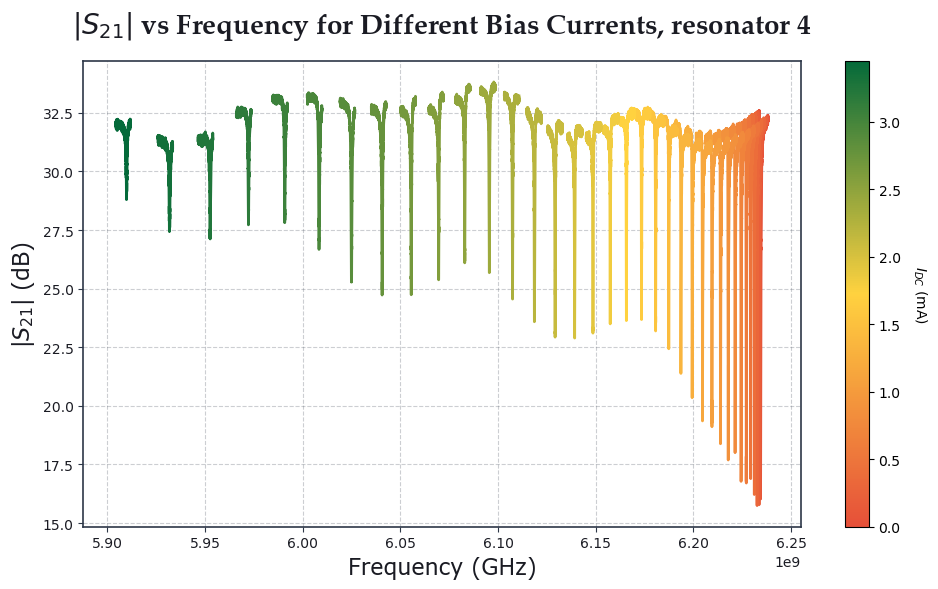

In [13]:
# Choose three nice colors for a smooth gradient: deep blue -> vibrant purple -> warm orange
gradient_colors = [
        '#1f4e79',  # Deep blue
        '#8e44ad',  # Vibrant purple  
        '#e67e22'   # Warm orange
]

gradient_colors_2 = [
    "#E65039",       # Vibrant coral - high-impact highlights
    '#FFD23F',  
    "#046A3A",

]

plt.figure(figsize=(10, 6))
#fig, (ax_main, ax_cbar) = plt.subplots(2, 1, figsize=(10, 8), 
                                      #gridspec_kw={'height_ratios': [0.3, 4], 'hspace': 0.3})

plot(f, S21_mag, 
                        title="$|S_{21}|$ vs Frequency for Different Bias Currents, resonator 4", 
                        palette=QSciencePalette, typography=QScienceTypography,
                        xlabel="Frequency (GHz)", ylabel="$|S_{21}|$ (dB)",
                        labels=None,  # Remove labels to hide legend
                        colors=gradient_colors_2,
                        gradient=True,
                        #ax=ax_main,
                        return_fig=True)


    # Create color bar to visualize the gradient
from matplotlib.colors import LinearSegmentedColormap
    
    # Create a custom colormap from our gradient colors
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors_2, N=256)

# Add colorbar

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r'$I_{DC}$ (mA)', rotation=270, labelpad=20)

    
#     # Create gradient bar
# gradient = np.linspace(0, 1, 256).reshape(1, -1)
# ax_cbar.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 7, 0, 1])
# ax_cbar.set_xlim(0, 7)
# ax_cbar.set_xlabel('Plot Number (shows color progression)', 
#                        fontname=QScienceTypography.body.font if QScienceTypography else None,
#                        fontsize=QScienceTypography.body.size if QScienceTypography else 12)
# ax_cbar.set_ylabel('Color\nGradient', 
#                        fontname=QScienceTypography.body.font if QScienceTypography else None,
#                        fontsize=QScienceTypography.body.size if QScienceTypography else 12)
# ax_cbar.set_yticks([])
    
#     # Add text annotations for the key colors
# ax_cbar.text(0, 1.2, 'Deep Blue', ha='left', va='bottom', 
#                 fontsize=10, color=gradient_colors[0], weight='bold')
# ax_cbar.text(3.5, 1.2, 'Vibrant Purple', ha='center', va='bottom', 
#                 fontsize=10, color=gradient_colors[1], weight='bold')
# ax_cbar.text(7, 1.2, 'Warm Orange', ha='right', va='bottom', 
#                 fontsize=10, color=gradient_colors[2], weight='bold')
    
#     # Style the color bar to match the palette
# if QSciencePalette:
#         text_color = str(QSciencePalette.colours['text_primary'])
#         axes_border_color = str(QSciencePalette.colours['neutral_dark'])
#         neutral_color = str(QSciencePalette.colours['neutral_light'])
        
#         ax_cbar.tick_params(axis='both', colors=axes_border_color, labelcolor=text_color)
#         for spine in ax_cbar.spines.values():
#             spine.set_edgecolor(axes_border_color)
#             spine.set_linewidth(1.2)
#         fig.patch.set_facecolor(neutral_color)

# Formatting
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r'$|S_{21}|$ (dB)')
# plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Peak at 5.8 MHz (run-2)

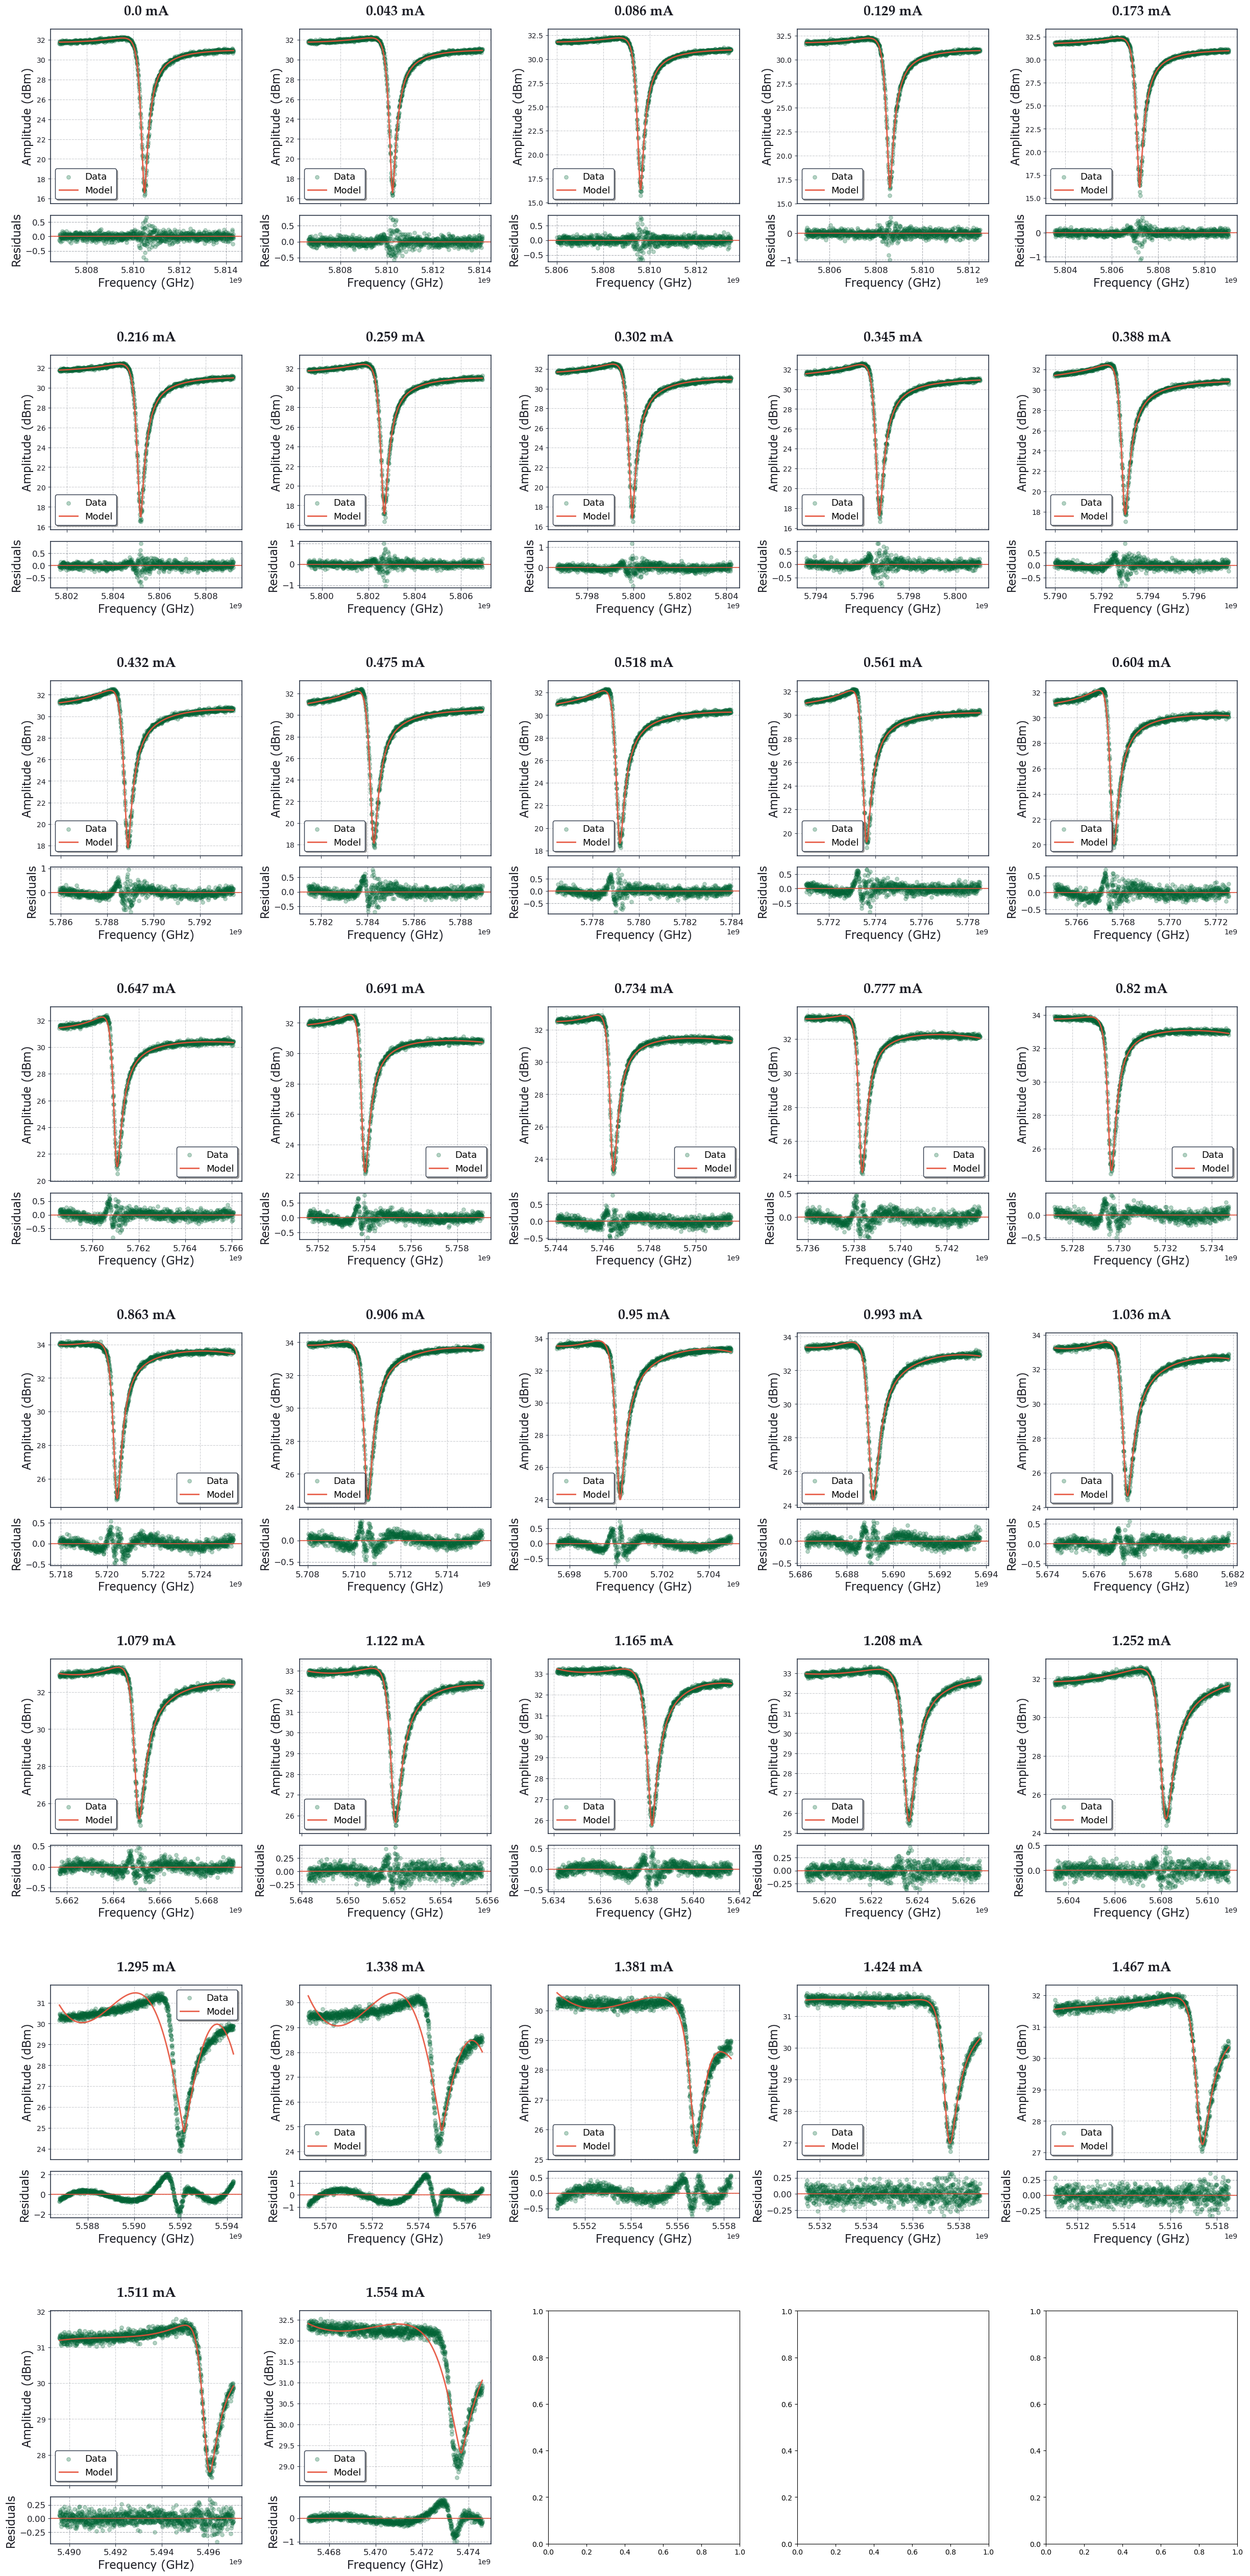

In [4]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-2/data/tr_sweep_data.h5')

resonance_frequneces_2 = []
bias_currents_2 = []
Qc_2 = []
Qt_2 = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks - changed to 5 columns
nrows = (nof_peaks + 4) // 5  # Calculate required rows for 5 columns

fig, ax = plt.subplots(nrows, 5, figsize=(30, nrows * 8), gridspec_kw={'hspace':0.4, 'wspace':0.3})

row_iter = 0
col_iter = 0

pippo = 0
for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    
    # try to fit
    model = md.resonance_model
    
    
    def Loss(x, y, yerr, model, names):
        """Loss function for the resonance model."""
        f0, phi, Qt, Qc, A, B, C, D, K, fmin = [x[names.index(name)] for name in names]
        model_values = model(f0=f0, phi=phi, Qt=Qt, Qc=Qc, A=A, B=B, C=C, D=D, K=K, fmin=fmin)
        ls = np.sum((x - model_values) ** 2)
        if Qc <= Qt:
            ls += 100  # Penalize if Qc is smaller than Qt
        return ls
    
    fitter = Fitter(model_function=model, 
                        param_names=["f0", "phi", "Qc", "Qt", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_manager=LeastSquares,
                    )

    searcher = ResonancePeakSearcher(version="T")
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces_2.append(resonance_frequency)
            bias_currents_2.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces_2.append(resonance_frequency)
            bias_currents_2.append(bias_current)
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            plot_fit(peak_data, model, fitted_params,
                     title=f'{round(bias_current, 3)} mA', 
                     xlabel='Frequency (GHz)', 
                     ylabel='Amplitude (dBm)', 
                     palette=palette, 
                     typography=typography, 
                     ax=ax[row_iter, col_iter],
                     rasterize_points=True)
            
            Qc_2.append(fitted_params['Qc'])
            Qt_2.append(fitted_params['Qt'])
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces_2.append(resonance_frequency)
        #bias_currents.append(bias_current)
        
    if pippo > 37:
        # delete ax
        fig.delaxes(ax[row_iter, col_iter])

    # update iterators - changed to 5 columns
    col_iter += 1
    pippo+=1
    if col_iter >= 5:  # Changed from 8 to 5 columns
        col_iter = 0
        row_iter += 1
    

plt.show()

In [5]:
# #Save the figure a svg file
# fig.savefig('../Analysis/figures/resonance_peaks_tunable_2.svg', bbox_inches='tight', dpi=300)

In [6]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces_2)
bias_currents = np.array(bias_currents_2)
resonance_frequneces_normalized -= resonance_frequneces_2[0]
resonance_frequneces_normalized /= resonance_frequneces_2[0] if resonance_frequneces_2[0] != 0 else 1

I_2 = 5.0362500266105705 +- 0.6520402919827513 mA
I_4 = 4.17246898602208 +- 3.102942097076216 mA


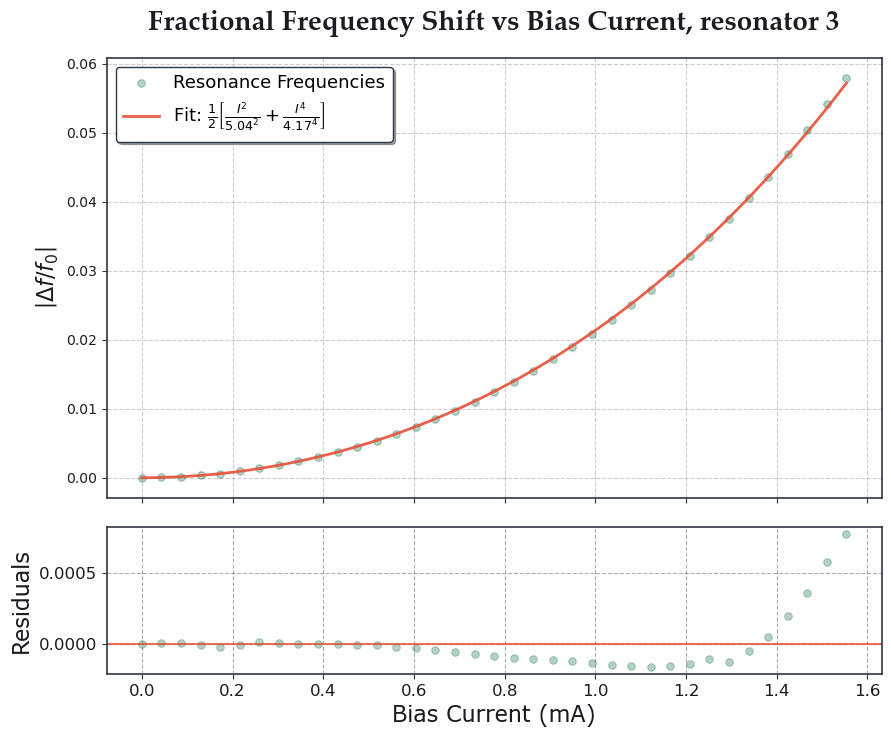

In [7]:
import matplotlib as mpl

# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, abs(resonance_frequneces_normalized)]).T, 
                    loss_manager=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()
error_params = result.errors.to_dict()
print(f"I_2 = {fitted_params["a"]} +- {error_params["a"]} mA")
print(f"I_4 = {fitted_params["b"]} +- {error_params["b"]} mA")

#model: 0.5*((i**2 / a**2) + (i**4 / b**4))

data = np.array([bias_currents, abs(resonance_frequneces_normalized)]).T
# Plot using LaTeX for text rendering
# enable LaTeX

# disable LaTeX rendering and use mathtext (Matplotlib's built-in math renderer)
mpl.rcParams['text.usetex'] = False

plot_fit(
    data=data,
    model=model,
    model_params=fitted_params,
    title=r'Fractional Frequency Shift vs Bias Current, resonator 3',
    xlabel=r'Bias Current (mA)',
    ylabel=r'$\left|\Delta f / f_0\right|$',  # mathtext will still render this correctly
    data_label=r'Resonance Frequencies',
    model_label=(
        r'Fit: $\frac{1}{2}\left[\frac{I^2}{%.2f^2} + \frac{I^4}{%.2f^4}\right]$'
        % (fitted_params["a"], fitted_params["b"])
    ),
    palette=palette,
    typography=typography,
    rasterize_points=False,
)
plt.show()

In [ ]:

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

f = []
S21_mag = []
colors = []

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f.append(peak_data[0])
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    S21_mag.append(20 * np.log10(amp * 1e3)) 
    colors.append(cmap(norm(bias_current)))
    #plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

<Figure size 1000x600 with 0 Axes>

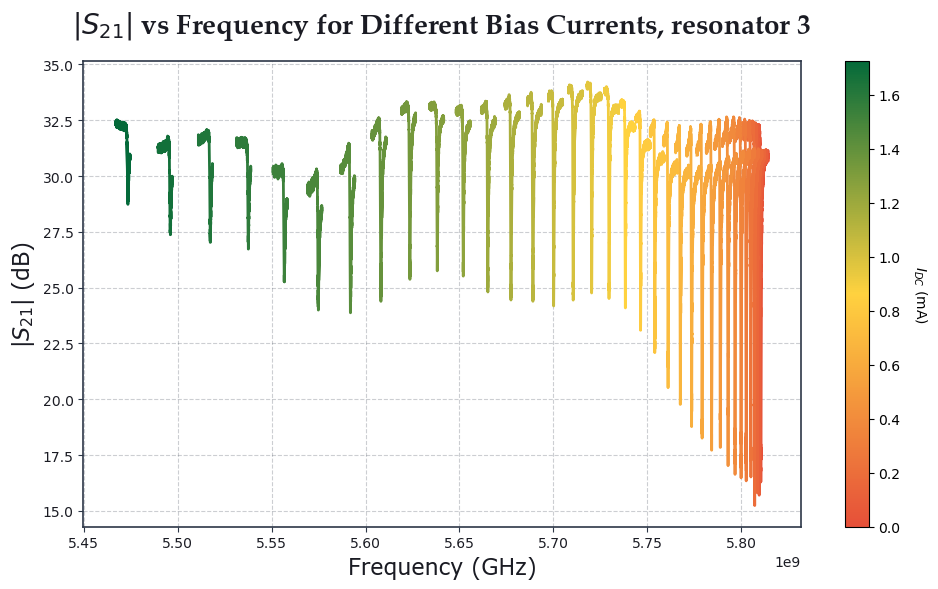

In [ ]:
# Choose three nice colors for a smooth gradient: deep blue -> vibrant purple -> warm orange
gradient_colors = [
        '#1f4e79',  # Deep blue
        '#8e44ad',  # Vibrant purple  
        '#e67e22'   # Warm orange
]

gradient_colors_2 = [
    "#E65039",       # Vibrant coral - high-impact highlights
    '#FFD23F',  
    "#046A3A",

]

plt.figure(figsize=(10, 6))
#fig, (ax_main, ax_cbar) = plt.subplots(2, 1, figsize=(10, 8), 
                                      #gridspec_kw={'height_ratios': [0.3, 4], 'hspace': 0.3})

plot(f, S21_mag, 
                        title="$|S_{21}|$ vs Frequency for Different Bias Currents, resonator 3", 
                        palette=QSciencePalette, typography=QScienceTypography,
                        xlabel="Frequency (GHz)", ylabel="$|S_{21}|$ (dB)",
                        labels=None,  # Remove labels to hide legend
                        colors=gradient_colors_2,
                        gradient=True,
                        #ax=ax_main,
                        return_fig=True)


    # Create color bar to visualize the gradient
from matplotlib.colors import LinearSegmentedColormap
    
    # Create a custom colormap from our gradient colors
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors_2, N=256)

# Add colorbar

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r'$I_{DC}$ (mA)', rotation=270, labelpad=20)

    
#     # Create gradient bar
# gradient = np.linspace(0, 1, 256).reshape(1, -1)
# ax_cbar.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 7, 0, 1])
# ax_cbar.set_xlim(0, 7)
# ax_cbar.set_xlabel('Plot Number (shows color progression)', 
#                        fontname=QScienceTypography.body.font if QScienceTypography else None,
#                        fontsize=QScienceTypography.body.size if QScienceTypography else 12)
# ax_cbar.set_ylabel('Color\nGradient', 
#                        fontname=QScienceTypography.body.font if QScienceTypography else None,
#                        fontsize=QScienceTypography.body.size if QScienceTypography else 12)
# ax_cbar.set_yticks([])
    
#     # Add text annotations for the key colors
# ax_cbar.text(0, 1.2, 'Deep Blue', ha='left', va='bottom', 
#                 fontsize=10, color=gradient_colors[0], weight='bold')
# ax_cbar.text(3.5, 1.2, 'Vibrant Purple', ha='center', va='bottom', 
#                 fontsize=10, color=gradient_colors[1], weight='bold')
# ax_cbar.text(7, 1.2, 'Warm Orange', ha='right', va='bottom', 
#                 fontsize=10, color=gradient_colors[2], weight='bold')
    
#     # Style the color bar to match the palette
# if QSciencePalette:
#         text_color = str(QSciencePalette.colours['text_primary'])
#         axes_border_color = str(QSciencePalette.colours['neutral_dark'])
#         neutral_color = str(QSciencePalette.colours['neutral_light'])
        
#         ax_cbar.tick_params(axis='both', colors=axes_border_color, labelcolor=text_color)
#         for spine in ax_cbar.spines.values():
#             spine.set_edgecolor(axes_border_color)
#             spine.set_linewidth(1.2)
#         fig.patch.set_facecolor(neutral_color)

# Formatting
# plt.xlabel('Frequency (GHz)')
# plt.ylabel(r'$|S_{21}|$ (dB)')
# plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()